In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import random
import numba
import statsmodels.api as sm
from sklearn.metrics import r2_score
import pandas as pd
import sys
import os


# Step 1: Add parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "/scratch/ivyglade/pdo/"))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Step 2: Now you can import file.py
import pdo_functions  # assuming file.py contains functions/classes

import importlib
importlib.reload(pdo_functions)

<module 'pdo_functions' from '/scratch/ivyglade/pdo/pdo_functions.py'>

In [2]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1870, 2024)

pdo['time'] = sst['time']

nino_34 = pdo_functions.oni_moving_base(sst)

/scratch/ivyglade/miniconda3/envs/myenv_py39/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.39.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [3]:
# 3- month rolling mean
nino_34_rolling = nino_34.rolling(time=3, center=True).mean()

In [4]:
# Calculating when El Nino or La Nina events occur (i.e. when ONI exceeds 0.5 for at least 5 consecutive months)
nino_34_calc = np.zeros((1668))
for i in range(1668):
    if i < 5:
        continue
    else:
        if (nino_34_rolling[(i-4)] > 0.5) & (nino_34_rolling[(i-3)] > 0.5) & (nino_34_rolling[(i-2)] > 0.5) & (nino_34_rolling[(i-1)] > 0.5) & (nino_34_rolling[i] > 0.5):
            nino_34_calc[i] = 1
        elif (nino_34_rolling[(i-4)] < -0.5) & (nino_34_rolling[(i-3)] < -0.5) & (nino_34_rolling[(i-2)] < -0.5) & (nino_34_rolling[(i-1)] < -0.5) & (nino_34_rolling[i] < -0.5):
            nino_34_calc[i] = -1
        else:
            continue

In [5]:
# convert nino_34_calc to xr
nino_34_calc_xr = xr.DataArray(nino_34_calc, coords={'time':nino_34_rolling['time']}, dims=['time'])

# 1940-2024 only
nino_34_1940_2024 = nino_34_calc_xr.sel(time=nino_34_calc_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5]))

In [6]:
# Selecting the PDO index only for MAM during 1940-2024'
pdo_1940_2024 = pdo.sel(time=pdo.time.dt.year.isin(np.arange(1940, 2025, 1)))
pdo_1940_2024_mam = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

In [7]:
# Need to calculate when El Nino/La Nina Occurs in a given year
nino_34_1940_2024_mam_ann = np.zeros((85))
for i in range(85):
    if nino_34_1940_2024_mam[i*3:i*3+3].sum(axis=0) > 0:
        nino_34_1940_2024_mam_ann[i] = 1

    elif nino_34_1940_2024_mam[i*3:i*3+3].sum(axis=0) < 0:
        nino_34_1940_2024_mam_ann[i] = -1

    else:
        continue

In [8]:
# Open NDSEV data
ndsev_diff = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ndsev/ndsev_1940-2024_mam_corrected.nc')['__xarray_dataarray_variable__'].load()

In [9]:
# creating land masks
land_110 = regionmask.defined_regions.natural_earth_v4_1_0.land_110
land = xr.where(land_110.mask_3D(ndsev_diff)==True, 1, np.nan).squeeze()
# east_land = xr.where(land_110.mask_3D(ndsev_diff_east)==True, 1, np.nan).squeeze()
# se_land = xr.where(land_110.mask_3D(ndsev_diff_se)==True, 1, np.nan).squeeze()

In [10]:
# Seasonal NDSEV counts
ndsev_diff_count = np.zeros((85, 101, 237))
for i in range(85):
    ndsev_diff_count[i] = (ndsev_diff.transpose('time', 'latitude', 'longitude')[i*92:(i+1)*92]).values.sum(axis=0)

In [11]:
# Convert to xarray
ndsev_diff_count_xr = xr.DataArray(ndsev_diff_count, coords={'time':pdo_1940_2024_mam['time'], 'latitude':ndsev_diff['latitude'], 'longitude':ndsev_diff['longitude']}, dims=['time', 'latitude', 'longitude'])

In [12]:
# Detrend
ndsev_diff_count_de = pdo_functions.detrend_dim(ndsev_diff_count_xr, 'time', 2)

In [13]:
ndsev_pos_pdo = xr.where(pdo_1940_2024_mam > 0, ndsev_diff_count_de, np.nan).dropna(dim='time')

In [15]:
# Regional subset - ndsev_normal is used for analysis
ndsev_normal = ndsev_diff_count_de.sel(latitude=slice(47, 30)).sel(longitude=slice(pdo_functions.convert_longitudes(-105), pdo_functions.convert_longitudes(-82)))
# ndsev_se     = ndsev_diff_count_de.sel(latitude=slice(35, 29)).sel(longitude=slice(pdo_functions.convert_longitudes(-93), pdo_functions.convert_longitudes(-81)))
# ndsev_central = ndsev_diff_count_de.sel(latitude=slice(45, 37)).sel(longitude=slice(pdo_functions.convert_longitudes(-106), pdo_functions.convert_longitudes(-96)))
# ndsev_south   = ndsev_diff_count_de.sel(latitude=slice(32, 24)).sel(longitude=slice(pdo_functions.convert_longitudes(-103), pdo_functions.convert_longitudes(-96)))

In [17]:
# Weight and take spatial mean
weights_normal = np.cos(np.deg2rad(ndsev_normal.latitude))
# weights_se = np.cos(np.deg2rad(ndsev_se.latitude))
# weights_central = np.cos(np.deg2rad(ndsev_central.latitude))
# weights_south = np.cos(np.deg2rad(ndsev_south.latitude))

ndsev_normal_wgt = ndsev_normal.weighted(weights_normal).mean(dim=('latitude', 'longitude'))
# ndsev_se_wgt = ndsev_se.weighted(weights_se).mean(dim=('latitude', 'longitude'))
# ndsev_central_wgt = ndsev_central.weighted(weights_central).mean(dim=('latitude', 'longitude'))
# ndsev_south_wgt = ndsev_south.weighted(weights_south).mean(dim=('latitude', 'longitude'))

In [18]:
# Take 5 year rolling means
ndsev_normal_rolling = ndsev_normal_wgt.rolling(time=5, center=True).mean()
# ndsev_se_rolling = ndsev_se_wgt.rolling(time=5, center=True).mean()
# ndsev_central_rolling = ndsev_central_wgt.rolling(time=5, center=True).mean()
# ndsev_south_rolling = ndsev_south_wgt.rolling(time=5, center=True).mean()

In [20]:
# Correlate the PDO index with the 5-year centered rolling mean of the PDO index
pearson_r, p = scipy.stats.pearsonr(pdo_1940_2024_mam[2:-2], ndsev_normal_rolling[2:-2])

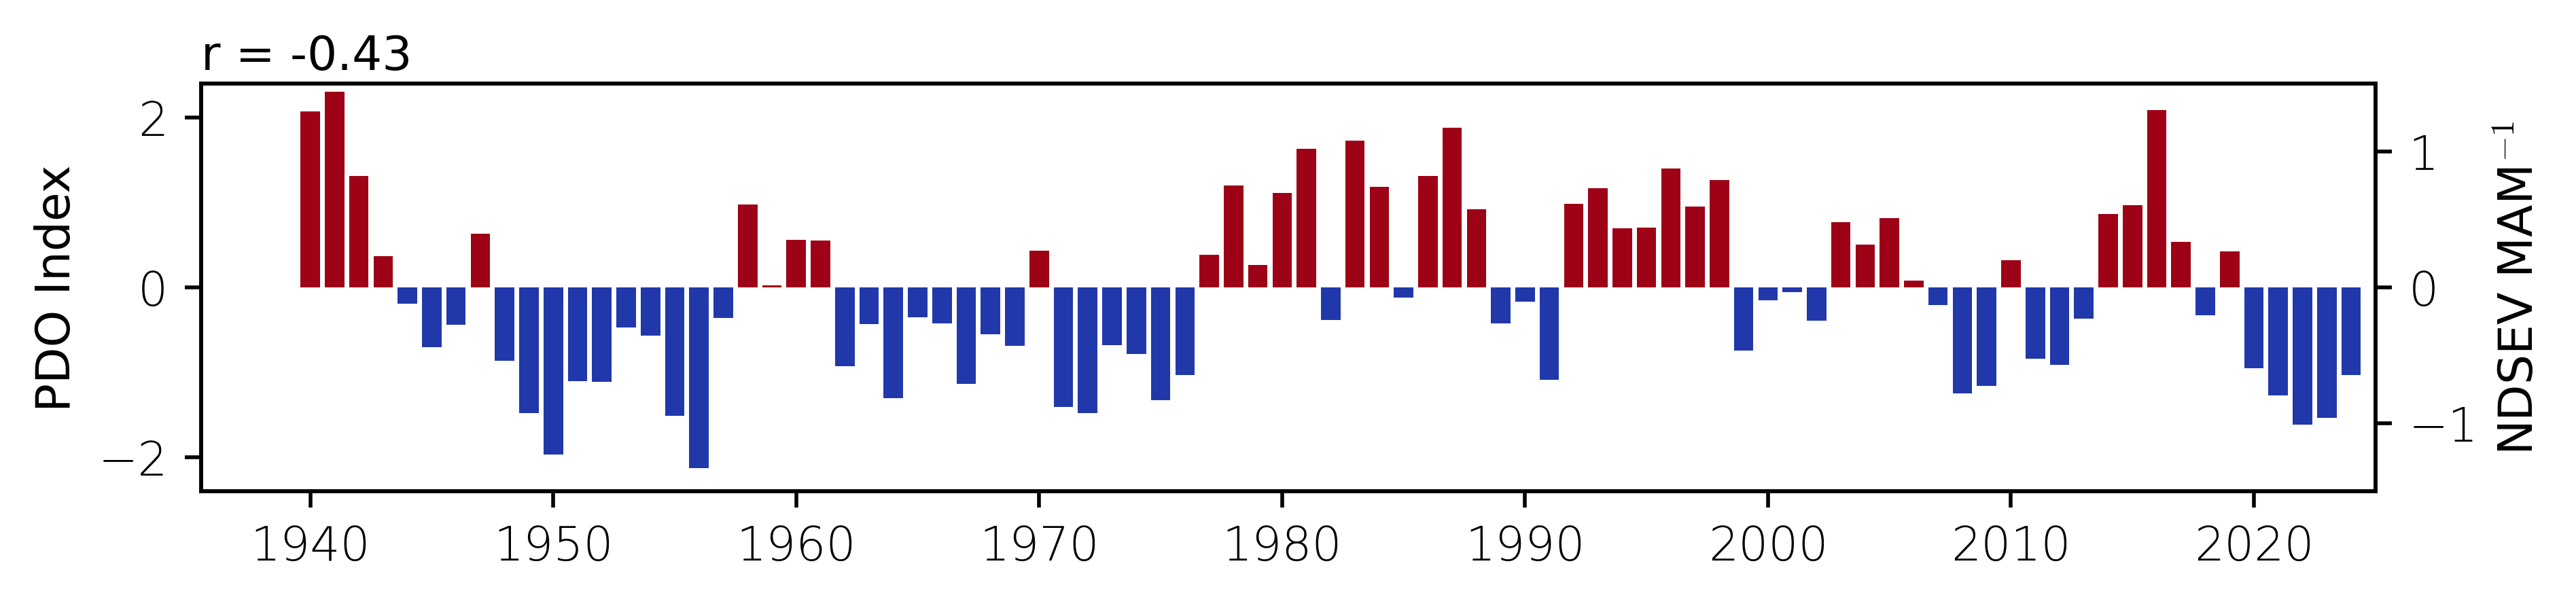

In [30]:
# Plotting
fig, ax = plt.subplots()

# plt.rcParams['text.usetex'] = True

years = np.arange(1940, 2025, 1)

# Plotting MAM average PDO
ax.bar(years[pdo_1940_2024_mam > 0], pdo_1940_2024_mam[pdo_1940_2024_mam > 0], color='xkcd:carmine')
ax.bar(years[pdo_1940_2024_mam < 0], pdo_1940_2024_mam[pdo_1940_2024_mam < 0], color='xkcd:sapphire')

# Set x and y-limits
ax.set_ylim(-2.4, 2.4)
ax.set_xlim(1935.5, 2025)
ax.set_ylabel('PDO Index', fontsize=10)

# Plotting MAMs where there was an El Niño or La Niña event
# ax.scatter(years[nino_34_1940_2024_mam_ann > 0], nino_34_1940_2024_mam_ann[nino_34_1940_2024_mam_ann > 0]*2.5, s=40, color='xkcd:dusky rose', marker='.')
# ax.scatter(years[nino_34_1940_2024_mam_ann < 0], nino_34_1940_2024_mam_ann[nino_34_1940_2024_mam_ann < 0]*2.5, s=40, color='xkcd:pastel blue', marker='.')
# ax.text(1935.8, 2.42, 'El Niño', color='xkcd:dusky rose', fontweight='normal', fontsize=5)
# ax.text(1935.8, -2.57, 'La Niña', color='xkcd:pastel blue', fontweight='normal', fontsize=5)
# ax.set_yticks([-2, -1, 0, 1, 2], fontsize=8)

# Second x-axis for plotting NDSEV time series
ax2 = ax.twinx()
# ax2.plot(years, ndsev_normal_rolling, color='black', lw=2)
ax2.set_ylim(-1.5, 1.5)
ax2.set_ylabel('NDSEV MAM$^{-1}$', fontsize=10)
# ax2.set_title('ECONUS MAM NDSEV 1940-2024', pad=3)

# Adding correlation value between the MAM average PDO and the 5-year rolling mean of eastern U.S. NDSEV
ax.set_title(f'r = {pearson_r:.2f}', loc='left', pad=3, fontsize=10)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.5, 
                    wspace=0.05, 
                    hspace=0.4)

# fig.savefig('/scratch/ivyglade/pdo/paper_figs/saved_pngs/Fig2_ndsev_timeseries.png', bbox_inches='tight', dpi=500)
fig.savefig('/scratch/ivyglade/pdo/paper_figs/saved_pngs/Fig2_ndsev_timeseries_agu_no_timeseries.png', bbox_inches='tight', dpi=500)